# Chess AI with PyTorch

By Marco Moscatelli

## Getting the data

### Installing the dependencies

In [1]:
!pip install python-chess
!pip install zstandard
!pip install py-cpuinfo
!pip install torch
!pip install torchsummary

### Extracting the data and creating the array with all PGNs

In [2]:
import re
import numpy as np

In [3]:
from time import time

In [4]:
try:
    start = time()
    games = np.load('games.npy')
    print(f"Time: {round(time()-start)}")
except:
    import zstandard as zstd

    start = time()

    # Open the compressed file
    with open('./lichess_db.pgn.zst', 'rb') as file:
        # Create a Zstandard decompressor
        dctx = zstd.ZstdDecompressor()

        # Decompress the file
        with dctx.stream_reader(file) as reader:
            uncompressed_data = reader.read()

    # Decode the uncompressed data
    pgn = uncompressed_data.decode('utf-8')
    pgns_string = re.sub(r'\[[^]]*\]', '', pgn)

    # optimize the space
    del pgn

    list_lines = pgns_string.split('\n')

    # Usiamo un ciclo for per rimuovere le righe vuote dalla lista
    lines_not_empty = []
    for riga in list_lines:
        if riga.strip():  # se la riga non è vuota
            lines_not_empty.append(riga)

    # Oppure, possiamo usare il metodo filter() per rimuovere le righe vuote dalla lista
    lines_not_empty = list(filter(lambda x: x.strip(), list_lines))

    # Uniamo le righe non vuote in una stringa
    stringa_senza_righe_vuote = '\n'.join(lines_not_empty)

    games = stringa_senza_righe_vuote.split('\n')
    games = np.array(games[:1000000])

    games.shape

    np.save('games.npy', games)
    
    print(f"Time: {round(time()-start)}")

Time: 114


In [5]:
games.shape

(1000000,)

### Importing stockfish in Python

#### Verify supported extensions by the CPU

In [6]:
import platform
import cpuinfo

# Verifica l'architettura della CPU
print(platform.architecture())

# Ottieni le informazioni sulla CPU
info = cpuinfo.get_cpu_info()

# Verifica se l'estensione AVX2 è supportata
print('AVX2 supportato: ', 'avx2' in info['flags'])

# Verifica se la popcount instruction è supportata
print('POPCNT supportato: ', 'popcnt' in info['flags'])

('64bit', 'WindowsPE')
AVX2 supportato:  True
POPCNT supportato:  True


#### Creating chess engine class

In [7]:
import chess.engine

In [8]:
stockfish_path = "./stockfish/stockfish-windows-2022-x86-64-avx2.exe"
engine = chess.engine.SimpleEngine.popen_uci(stockfish_path) 

#### Testing stockfish eval

In [9]:
import chess.pgn
import io
import subprocess

pgn_file = io.StringIO(games[0])

game = chess.pgn.read_game(pgn_file)
board = game.board()

for i, move in enumerate(game.mainline_moves()):
  board.push(move)

print(board)

info = engine.analyse(board, chess.engine.Limit(time=2.0))

centipawn = int(str(info['score']).replace("PovScore(Cp(", "").replace(")", "").split(',')[0])

print(f"Punteggio : {centipawn}")

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R
Punteggio : 23


### Creating utility functions

In [10]:
import chess

In [11]:
squares_index = {
  'a':0,
  'b':1,
  'c':2,
  'd':3,
  'e':4,
  'f':5,
  'g':6,
  'h':7,
}

In [12]:
def square_to_index(square):
  letter = chess.square_name(square)
  return 8-int(letter[1]), squares_index[letter[0]]

def get_board_array(board):
    
    pieces_position = np.zeros([14, 8, 8])

    for i in range(8):
      for j in range(8):
        square = chess.square(j, i)
        piece = board.piece_at(square)
        valueBoard = 0 if piece is not None and  piece.color == chess.WHITE else 6

        # creazione per i pezzi bianchi
        if piece is not None and piece.piece_type == chess.PAWN:
          pieces_position[0 + valueBoard, 7-i, j] = 1
        elif piece is not None and piece.piece_type == chess.ROOK:
          pieces_position[1 + valueBoard, 7-i, j] = 1
        elif piece is not None and piece.piece_type == chess.KNIGHT:
          pieces_position[2 + valueBoard, 7-i, j] = 1
        elif piece is not None and piece.piece_type == chess.BISHOP:
          pieces_position[3 + valueBoard, 7-i, j] = 1
        elif piece is not None and piece.piece_type == chess.QUEEN:
          pieces_position[4 + valueBoard, 7-i, j] = 1
        elif piece is not None and piece.piece_type == chess.KING:
          pieces_position[5 + valueBoard, 7-i, j] = 1
    
    
    aux = board.turn
    board.turn = chess.WHITE
    for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      pieces_position[12, i, j] = 1
      
    board.turn = chess.BLACK
    for move in board.legal_moves:
      i, j = square_to_index(move.to_square)
      pieces_position[13, i, j] = 1
    board.turn = aux
        

    return pieces_position

In [13]:
board = chess.Board()

print(get_board_array(board))

[[[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 1. 1. 1. 1. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 1. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 1. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 

In [14]:
board = chess.Board()

board.push_san('e4')
board.push_san('e5')

print(get_board_array(board))

[[[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 1. 1. 1. 0. 1. 1. 1.]
  [0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [1. 0. 0. 0. 0. 0. 0. 1.]]

 [[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 1. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 1. 0. 0.]]

 [[0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 

## Creating the dataset

In [15]:
data_path = "./data.npy"
labels_path = "./labels.npy"
perm_path = "./permutations.npy"
made_positions_path = "./made_positions.npy"

In [16]:
np.random.seed(42)

# l'array iniziale e' la posizione senza mosse
board = game.board()

try:
  already_made_positions = np.load(made_positions_path)
except:
  print('Creating made_positions')
  board = chess.Board()
  already_made_positions = np.array([str(board)], dtype=str)

try:
  data = np.load(data_path)
except:
  print('Creating data')
  data = get_board_array(board).reshape(1, 14, 8, 8)

try:
  labels = np.load(labels_path)
except:
  print('Creating labels')
  labels = np.array([int(str(engine.analyse(board, chess.engine.Limit(time=2.0, depth=14))['score']).replace("PovScore(Cp(", "").replace(")", "").split(',')[0])])

try:
  perm = np.load(perm_path)
except: 
  print('Creating perm')
  perm = np.random.permutation(len(games))

Creating made_positions
Creating data
Creating labels
Creating perm


In [17]:
import sys

In [18]:
import copy

In [19]:
nGames = 250000
selectedGames = copy.deepcopy(games[perm[:nGames]])
del games

In [33]:
for index_game, game in enumerate(selectedGames):
    
  sys.stdout.write(f"\rDoing game number {index_game + 1} of {len(selectedGames)}")
  sys.stdout.flush()

  pgn_file = io.StringIO(game)
  game = chess.pgn.read_game(pgn_file)
  board = game.board()

  for i, move in enumerate(game.mainline_moves()):

    board.push(move)

    if not np.any(np.char.equal(already_made_positions, str(board))):
      
      board_array = get_board_array(board)

      already_made_positions = np.append(already_made_positions, str(board))

      # ottenere lo score della posizione
      info = engine.analyse(board, chess.engine.Limit(depth=15))
      if(not info['score'].is_mate()):
        centipawn = int(str(info['score']).replace("PovScore(Cp(", "").replace(")", "").split(',')[0])
        if((i+1)%2 != 0):
          centipawn = centipawn * -1

        # aggiungere dati al dataset
        data = np.concatenate((data, board_array.reshape(1, 14, 8, 8)), axis=0)
        labels = np.append(labels, centipawn)

Doing game number 448 of 250000

KeyboardInterrupt: 

In [34]:
np.save("data.npy", data)
np.save("labels.npy", labels)
np.save('made_positions.npy', already_made_positions)
np.save("permutations.npy", perm)

In [35]:
data.shape, labels.shape, already_made_positions.shape

((25603, 14, 8, 8), (25603,), (27127,))

## PyTorch model

### Splitting the data

In [36]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [37]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [38]:
dataT = torch.Tensor(data).to(device)
labelsT = torch.Tensor((labels/100).reshape(len(labels), 1)).to(device)

In [39]:
dataT.shape

torch.Size([25603, 14, 8, 8])

In [40]:
labelsT.shape

torch.Size([25603, 1])

In [41]:
train, test, train_labels, test_labels = train_test_split(dataT, labelsT, train_size=0.975, shuffle=True)

train_data = TensorDataset(train, train_labels)
test_data = TensorDataset(test, test_labels)

batchsize = 64
train_loader  = DataLoader(train_data, batchsize, False, drop_last=True)
test_loader  = DataLoader(train_data, test_data.tensors[0].shape[0], False, drop_last=True)

### Create the model

In [93]:
class modelCreator(nn.Module):
  def __init__(self):
    super().__init__()

    self.layers = nn.ModuleDict()

    self.layers['conv1'] = nn.Conv2d(14, 32, 3, padding='same')
    self.layers['pool1'] = nn.MaxPool2d(2, 2)
    self.layers['bnorm1'] = nn.BatchNorm2d(32)
    self.layers['act1'] = nn.ReLU()
    # (8 + 2 - 3)/1 + 1 -> pooling -> 4
    self.layers['conv2'] = nn.Conv2d(32, 128, 3, padding='same')
    self.layers['pool2'] = nn.MaxPool2d(2, 2)
    self.layers['bnorm2'] = nn.BatchNorm2d(128)
    self.layers['act2'] = nn.ReLU()
    # (6 + 2 - 3)/1 + 1 -> pooling -> 2

    self.layers['flatten'] = nn.Flatten()

    self.layers['fc1'] = nn.Linear(128*2*2, 128)
    self.layers['act3'] = nn.ReLU()
    self.layers['drop1'] = nn.Dropout(p=.3)
    
#     self.layers['fc2'] = nn.Linear(256, 256)
#     self.layers['act4'] = nn.ReLU()
#     self.layers['drop2'] = nn.Dropout(p=.3)
    
    self.layers['fc4'] = nn.Linear(128, 1)

  def forward(self, x):
    for name, layer in self.layers.items():
      x = layer(x)
    return x

In [94]:
net = modelCreator().to(device)
lossfun = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=.001, weight_decay=0.001)

In [95]:
from torchsummary import summary

In [96]:
summary(net, (14, 8, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 32, 8, 8]           4,064
         MaxPool2d-2             [-1, 32, 4, 4]               0
       BatchNorm2d-3             [-1, 32, 4, 4]              64
              ReLU-4             [-1, 32, 4, 4]               0
            Conv2d-5            [-1, 128, 4, 4]          36,992
         MaxPool2d-6            [-1, 128, 2, 2]               0
       BatchNorm2d-7            [-1, 128, 2, 2]             256
              ReLU-8            [-1, 128, 2, 2]               0
           Flatten-9                  [-1, 512]               0
           Linear-10                  [-1, 128]          65,664
             ReLU-11                  [-1, 128]               0
          Dropout-12                  [-1, 128]               0
           Linear-13                    [-1, 1]             129
Total params: 107,169
Trainable params:

### Test if the model works

In [97]:
X, y = next(iter(test_loader))

In [98]:
loss = lossfun(net(X), y)
print(loss.item())

45.47834777832031


### Training the model

In [99]:
epochs = 1000

losses = torch.zeros(epochs)
test_losses = torch.zeros(epochs)

bestNet = {
    'loss': 10000,
    'net': None
}

for epoch in range(epochs):

  sys.stdout.write(f"\rDoing epoch number {epoch+1} of {epochs}, train loss: {losses[epoch-1] if epoch != 0 else 'Unknown'}, test loss: {test_losses[epoch-1] if epoch != 0 else 'Unknown'}, bestloss: {bestNet['loss']}")
  sys.stdout.flush()

  batchLosses = []

  for X, y in train_loader:

    yHat = net(X)

    loss = lossfun(yHat, y)
    batchLosses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

        
  losses[epoch] = np.mean(batchLosses)
  X,y = next(iter(test_loader))
  with torch.no_grad():
    yHat = net(X)
  loss = lossfun(yHat, y)
  test_losses[epoch] = float(loss)
  if(float(loss) < bestNet['loss']):
      bestNet['loss'] = float(loss)
      bestNet['net'] = copy.deepcopy(net.state_dict())

Doing epoch number 133 of 1000, train loss: 1.0819416046142578, test loss: 1.387932538986206, bestloss: 0.95942616462707522

KeyboardInterrupt: 

In [100]:
bestModel = modelCreator()
bestModel.load_state_dict(bestNet['net'])
torch.save(bestModel.state_dict, 'trained_model.pt')

### Evaluating the performance

In [101]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Test Losses')

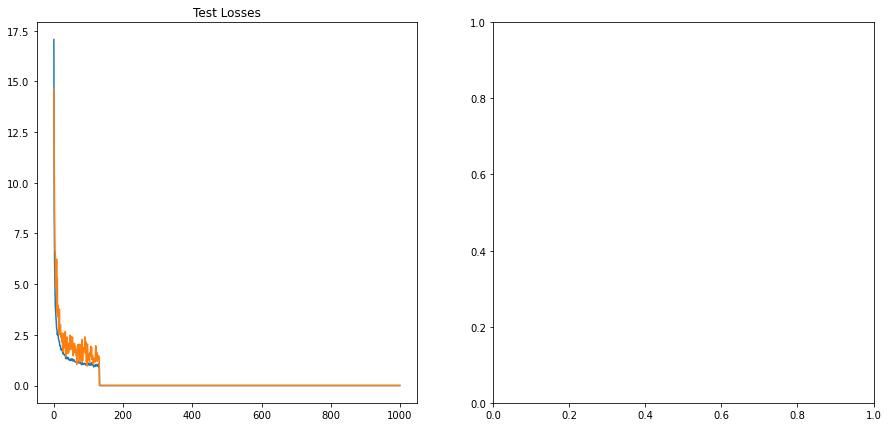

In [102]:
fig, axs = plt.subplots(1, 2, figsize=[15, 7])

axs[0].plot(losses)
axs[0].set_title('Train Losses')

axs[0].plot(test_losses)
axs[0].set_title('Test Losses')

In [103]:
X, y = next(iter(test_loader))
yHat = bestModel(X)
print(lossfun(yHat, y))

tensor(1.2555, grad_fn=<MseLossBackward0>)


## Creating the engine

### Creating the minimax function

In [106]:
def minimax_eval(board):
  board3d = get_board_array(board)
  return net(torch.Tensor(board3d).view(1, 14, 8, 8))

def minimax(board, depth, alpha, beta, maximizing_player):
  if depth == 0 or board.is_game_over():
    return minimax_eval(board)
  
  if maximizing_player:
    max_eval = float('-inf')
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth - 1, alpha, beta, False)
      board.pop()
      max_eval = max(max_eval, eval)
      if beta <= alpha:
        break
    return max_eval
  else:
    min_eval = float('inf')
    for move in board.legal_moves:
      board.push(move)
      eval = minimax(board, depth-1, alpha, beta, True)
      board.pop()
      min_eval = min(min_eval, eval)
      if beta <= alpha:
        break
    return min_eval
  
def get_ai_move(board, depth):
  max_move = None
  max_eval = float('-inf')
  
  for move in board.legal_moves:
    board.push(move)
    eval = minimax(board, depth - 1, float('-inf'), float('inf'), False)
    board.pop()
    if eval > max_eval:
      max_eval = eval
      max_move = move
  return max_move

In [126]:
board = chess.Board()

  
while True:
  if(player == 'W'):
    aimove = get_ai_move(board, 1)
    print(f'Ai: {board.san(aimove)}\n')
    
    board.push(aimove)
      
    print(str(board) + '\n')
    
    move = input('Move:')
    board.push_san(move)
    
    print('\n' + str(board) + '\n')
    
    print('-----------\n')
    
    if board.is_game_over():
      break
    
board

Ai: Nf3

r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . N . .
P P P P P P P P
R N B Q K B . R

Move:e6

r n b q k b n r
p p p p . p p p
. . . . p . . .
. . . . . . . .
. . . . . . . .
. . . . . N . .
P P P P P P P P
R N B Q K B . R

-----------

Ai: Na3

r n b q k b n r
p p p p . p p p
. . . . p . . .
. . . . . . . .
. . . . . . . .
N . . . . N . .
P P P P P P P P
R . B Q K B . R

Move:Bxa3

r n b q k . n r
p p p p . p p p
. . . . p . . .
. . . . . . . .
. . . . . . . .
b . . . . N . .
P P P P P P P P
R . B Q K B . R

-----------

Ai: h3

r n b q k . n r
p p p p . p p p
. . . . p . . .
. . . . . . . .
. . . . . . . .
b . . . . N . P
P P P P P P P .
R . B Q K B . R

Move:c6

r n b q k . n r
p p . p . p p p
. . p . p . . .
. . . . . . . .
. . . . . . . .
b . . . . N . P
P P P P P P P .
R . B Q K B . R

-----------

Ai: g4

r n b q k . n r
p p . p . p p p
. . p . p . . .
. . . . . . . .
. . . . . . P .
b . . . . N . P
P P P P P P . .
R . B Q K B 

KeyboardInterrupt: Interrupted by user

## Doing a real match

In [ ]:
# Crea una scacchiera
board = chess.Board()

# Esegui una mossa
move = chess.Move.from_uci("e2e4")
board.push(move)

# Ottieni la lista di posizioni valide per la prossima mossa
valid_moves = [str(move) for move in board.generate_legal_moves()]
print(valid_moves)

In [ ]:
board = chess.Board()

board.push_san(None)

board